## Sentiment Classification: classifying IMDB reviews

In this task, you will learn how to process text data and how to train neural networks with limited input text data using pre-trained embeddings for sentiment classification (classifying a review document as "positive" or "negative" based solely on the text content of the review).

We will use the `Embedding` layer in Keras to represent text input. The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, then looks up these integers into an internal dictionary, and finally returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have  shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer.

You can instantiate the `Embedding` layer by randomly initialising its weights (its internal dictionary of token vectors). During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for. You can also instantiate the `Embedding` layer by intialising its weights using the pre-trained word embeddings, such as GloVe word embeddings pretrained from Wikipedia articles.

#### a) Download the IMDB data as raw text

First, create a "data" directory, then head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Save it into the "data" directory. Uncompress it. Store the individual reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a separate `labels` list.

In [1]:
import os

# write your code here

# Read the IMDB data from train/test and pos/neg dirctory 
# (I don't know what is 'unsup' in 'train' for)
DATA_DIR = './aclImdb_v1/'
label_dic = {'pos': 1, 'neg': 0} # to improve the runing efficiency

reviews = [] # a list of review, one string per review
labels = [] # a list of label: positive - 1, negative - 0
for eachset in ('train', 'test'):
    for label in ('pos', 'neg'):
        path = os.path.join(DATA_DIR, eachset, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            reviews.append(txt)
            labels.append(label_dic[label])

#### b) Pre-process the review documents 

Pre-process review documents by tokenisation and split the data into the training and testing sets. You can restrict the training data to the first 1000 reviews and only consider the top 5,000 words in the dataset. You can also cut reviews after 100 words (that is, each review contains a maximum of 100 words).

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# write your code here

max_words = 5000 # consider the top 5,000 words in the dataset
max_len = 100 # each review contains a maximum of 100 words
training_sample = 1000 # restrict the number of training data to 1000

# tokenize the reviews
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
X = pad_sequences(sequences, maxlen=max_len)
Y = np.array(labels)

# according to the order of reading data, split the test set and training set
X_test = X[25000:]
Y_test = Y[25000:]
X_train_all = X[:25000]
Y_train_all = Y[:25000]

# randomly select 1000 reviews from the original training set
order = np.arange(25000)
np.random.seed(1234)
np.random.shuffle(order)
X_train_all = X_train_all[order]
Y_train_all = Y_train_all[order]
X_train = X_train_all[:training_sample]
Y_train = Y_train_all[:training_sample]
# use the rest of original training set as validation set
X_val = X_train_all[training_sample:]
Y_val = Y_train_all[training_sample:]

Using TensorFlow backend.


#### c) Download the GloVe word embeddings and map each word in the dataset into its pre-trained GloVe word embedding.

First go to `https://nlp.stanford.edu/projects/glove/` and download the pre-trained 
embeddings from 2014 English Wikipedia into the "data" directory. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

Parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number vectors).

Build an embedding matrix that will be loaded into an `Embedding` layer later. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [72]:
# write your code here

# read glove file to a dictionary, with word and its vector
embeddings_index = {}
with open('./glove.6B/glove.6B.100d.txt', 
          'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:])
        embeddings_index[word] = coefs

# build an embedding matrix with shape (max_words, embedding_dim)
embeddings_matrix = np.zeros((max_words, 100))
for word, index in tokenizer.word_index.items():
    if index < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[index] = embedding_vector

#### d) Build and train a simple Sequential model

The model contains an Embedding Layer with maximum number of tokens to be 10,000 and embedding dimensionality as 100. Initialise the Embedding Layer with the pre-trained GloVe word vectors. Set the maximum length of each review to 100. Flatten the 3D embedding output to 2D and add a Dense Layer which is the classifier. Train the model with a 'rmsprop' optimiser. You need to freeze the embedding layer by setting its `trainable` attribute to `False` so that its weights will not be updated during training.

In [86]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# write your code here

# build a sequential model
model = Sequential()
# the max_words defined in b) is 5000, why it changes to 10,000 in d) ?
# anyway, I still use 5000 as max_words here.
model.add(Embedding(max_words, 100, input_length = max_len, 
                    weights=[embeddings_matrix],trainable = False))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid")) 

# compile the model
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

#fit the model with training set and validation set
history = model.fit(X_train, Y_train,
                   epochs = 16,
                   batch_size = 32,
                   validation_data = (X_val, Y_val))

Train on 1000 samples, validate on 24000 samples
Epoch 1/16
1000/1000 [==============================] - 3s 3ms/step - loss: 0.8694 - acc: 0.5340 - val_loss: 0.6894 - val_acc: 0.5853
Epoch 2/16
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6083 - acc: 0.6740 - val_loss: 0.7870 - val_acc: 0.5630
Epoch 3/16
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4455 - acc: 0.8010 - val_loss: 1.0300 - val_acc: 0.5244
Epoch 4/16
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4052 - acc: 0.8140 - val_loss: 0.7450 - val_acc: 0.5872
Epoch 5/16
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3132 - acc: 0.8880 - val_loss: 0.8216 - val_acc: 0.5720
Epoch 6/16
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2344 - acc: 0.9330 - val_loss: 0.7075 - val_acc: 0.6200
Epoch 7/16
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1980 - acc: 0.9420 - val_loss: 1.0677 - val_acc: 0.5526
Epoch 8/16
10

#### e) Plot the training and validation loss and accuracies and evaluate the trained model on the test set.

What do you observe from the results?

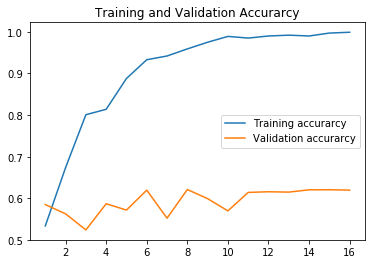

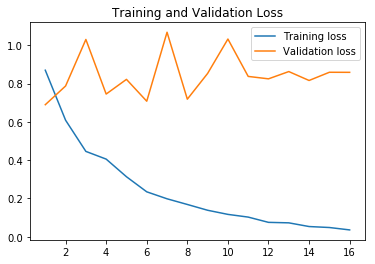

The accuracy is 61.8%
Classification Report
               precision    recall  f1-score   support

           0       0.61      0.66      0.63     12500
           1       0.63      0.58      0.60     12500

   micro avg       0.62      0.62      0.62     25000
   macro avg       0.62      0.62      0.62     25000
weighted avg       0.62      0.62      0.62     25000



In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# write your code here

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# evaluate in test set: accuracy and calssification report
Y_pred = np.around(model.predict_proba(X_test))
print("The accuracy is {:.1%}".format(accuracy_score(Y_test,Y_pred)))
print("Classification Report\n",classification_report(Y_test,Y_pred))

#### Finding:
The accuracy of training set and validation differs a lot with 1.0 and 0.6. The loss of them is the same with 0.0 and 0.8.   
It seems that the model is overfitted in the training set, partly due to the small amount of training set.  
And the accuracy of test set is 61.8%.

#### f) Add an LSTM layer into the simple neural network architecture and re-train the model on the training set, plot the training and validation loss/accuracies, also evaluate the trained model on the test set and report the result.

Train on 1000 samples, validate on 24000 samples
Epoch 1/16
1000/1000 [==============================] - 21s 21ms/step - loss: 0.7255 - acc: 0.5250 - val_loss: 0.7256 - val_acc: 0.5061
Epoch 2/16
1000/1000 [==============================] - 13s 13ms/step - loss: 0.6613 - acc: 0.5980 - val_loss: 0.6620 - val_acc: 0.5835
Epoch 3/16
1000/1000 [==============================] - 14s 14ms/step - loss: 0.6207 - acc: 0.6450 - val_loss: 0.6266 - val_acc: 0.6532
Epoch 4/16
1000/1000 [==============================] - 13s 13ms/step - loss: 0.5640 - acc: 0.7250 - val_loss: 0.6215 - val_acc: 0.6631
Epoch 5/16
1000/1000 [==============================] - 13s 13ms/step - loss: 0.5269 - acc: 0.7460 - val_loss: 0.5851 - val_acc: 0.6950
Epoch 6/16
1000/1000 [==============================] - 13s 13ms/step - loss: 0.5195 - acc: 0.7540 - val_loss: 0.5710 - val_acc: 0.7064
Epoch 7/16
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4930 - acc: 0.7710 - val_loss: 0.5660 - val_acc: 0.7086

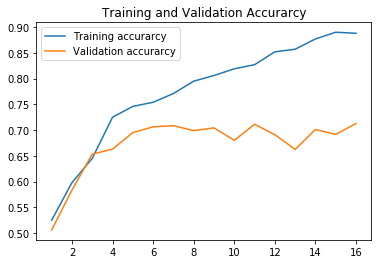

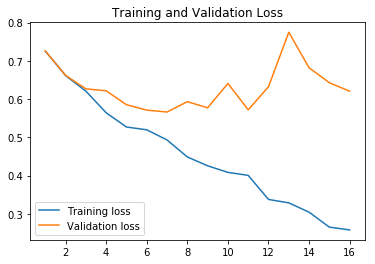

The accuracy is 71.1%
Classification Report
               precision    recall  f1-score   support

           0       0.72      0.69      0.70     12500
           1       0.70      0.73      0.72     12500

   micro avg       0.71      0.71      0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000



In [110]:
from keras.layers import LSTM, Dropout

# write your code here
model2 = Sequential()
model2.add(Embedding(max_words, 100, input_length = max_len, 
                    weights=[embeddings_matrix],trainable = False))
model2.add(LSTM(32, return_sequences=True))
model2.add(Flatten())
model2.add(Dropout(0.5)) # to avoid overfitting
model2.add(Dense(1, activation="sigmoid")) 

model2.compile(loss='binary_crossentropy', # binary classification
              optimizer='rmsprop',
              metrics=['accuracy'])

history2 = model2.fit(X_train, Y_train,
                   epochs = 16,
                   batch_size = 32,
                   validation_data = (X_val, Y_val))

# Plot the training/validation loss and accuracy
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# evaluate in test set: accuracy and calssification report
Y_pred2 = np.around(model2.predict_proba(X_test))
print("The accuracy is {:.1%}".format(accuracy_score(Y_test,Y_pred2)))
print("Classification Report\n",classification_report(Y_test,Y_pred2))

#### Finding:
After adding the LSTM layer and Dropout layer, the performance in validation set has been improved.  
The accuracy of test set is also improved to 71.1%.